# Atom types

In this notebook, we explore **atom types** frequencies in cleaned, incremental-scheme, PDB files.

By atom types we mean **element symbols** (this is the name of the column in the official PDB format description), for example `N` for nitrogen, `C` for carbon etc.

To run this notebook, you need to run through `processing` notebooks `00`, `01`, `02` and `03` (`pdb2fasta`) first - so you would have the unaligned FASTA datasets generated.

---

## Setup

In [1]:
import os

import pandas as pd
import seaborn as sns
from biopandas.pdb import PandasPdb
from tqdm.notebook import tqdm

import bin.params as params
import bin.utils as utils

In [2]:
sns.set_theme()
sns.set(rc = {'figure.figsize':(12,6)})

**Load unaligned FASTA dataset:**

In [3]:
FASTA_UNALIGNED_CSV = f'{params.DATA_DIR}/csv/fasta_unaligned/fasta_all.csv'
fasta_df = pd.read_csv(FASTA_UNALIGNED_CSV, index_col=0)

**Create a directory to store the atom counts `.csv` datasets in (if it does not exist already):**

In [4]:
ATOM_COUNTS_DIR = f'{params.DATA_DIR}/csv/atom_counts'
command = f'mkdir -p {ATOM_COUNTS_DIR}'
! $command

## Theory

**We load cleaned PDB files into `biopandas` dataframes, which look like this:**

In [16]:
p = PandasPdb().read_pdb(f'{params.DATA_DIR}/pdb/chothia/1a7r.pdb')
p.df['ATOM'].head(n=2)

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,GLN,,H,1,,...,-7.404,44.620,37.768,1.0,29.62,,,N,NaN,4
1,ATOM,2,,CA,,GLN,,H,1,,...,-8.563,43.726,37.825,1.0,25.50,,,C,NaN,5


## Compute atom type counts per PDB file

In [8]:
AA_TO_NUMBER_OF_ATOMS_MAP = { # without hydrogens
    'A': 6, 'C': 7, 'D': 9, 'E': 10,
    'F': 12, 'G': 5, 'H': 11, 'I': 9, 
    'K': 10, 'L': 9, 'M': 9, 'N': 9, 
    'P': 8, 'Q': 10, 'R': 12, 'S': 7,      
    'T': 8, 'V': 8, 'W': 15, 'Y': 13
}

In [9]:
def compute_aa_number_from_seq(seq: str) -> int:
    return sum(AA_TO_NUMBER_OF_ATOMS_MAP[aa] for aa in seq)

**Compute atom frequencies (this may take a while):**

In [11]:
all_atom_types = set()
chain_dicts = dict()
fasta_records = list(fasta_df.iterrows())
for chain_key, row in tqdm(fasta_records):
    seq = row.sum().replace('-', '')
    structure_code = chain_key[:4].lower()
    
    chain_ids = ['K', 'L'] if chain_key[:-1] == 'L' else ['H']
    seq_df = PandasPdb().read_pdb(f'{params.DATA_DIR}/pdb/incremental/{structure_code}.pdb').df['ATOM']
    chain_df = seq_df[ (seq_df['chain_id'].isin(chain_ids)) & (seq_df['element_symbol'] != 'H') ]
    
    chain_dict = dict(chain_df['element_symbol'].value_counts())
    all_atom_types = all_atom_types.union(chain_dict.keys())
    chain_dict['theoretical'] = compute_aa_number_from_seq(seq)
    chain_dicts[chain_key] = chain_dict

  0%|          | 0/6572 [00:00<?, ?it/s]

In [12]:
atom_counts_df = pd.DataFrame(0, index=chain_dicts.keys(), columns=list(all_atom_types) + ['theoretical'])

In [13]:
for structure_code, structure_dict in chain_dicts.items():
    for atom, count in structure_dict.items():
        atom_counts_df.loc[structure_code, atom] = count

**Store in `.csv` files:**

In [14]:
atom_counts_df.to_csv(f'{ATOM_COUNTS_DIR}/atom_counts_all.csv')
utils.select_only_chain_sequences(atom_counts_df, 'L').to_csv(f'{ATOM_COUNTS_DIR}/atom_counts_L.csv')
utils.select_only_chain_sequences(atom_counts_df, 'H').to_csv(f'{ATOM_COUNTS_DIR}/atom_counts_H.csv')

## Visualizations

**Load the atom counts from csv file:**

In [5]:
atom_counts_df = pd.read_csv(f'{ATOM_COUNTS_DIR}/atom_counts_all.csv', index_col=0)

**Show the `atom_counts` dataframe:**

In [6]:
atom_counts_df.head(n=3)

,O,N,C,S,theoretical
12E8:H,336,276,1064,6,1902
12E8:L,336,276,1064,6,1862
15C8:H,330,262,1028,6,1842


### Total number of atoms per chain

**Show the histogram:**

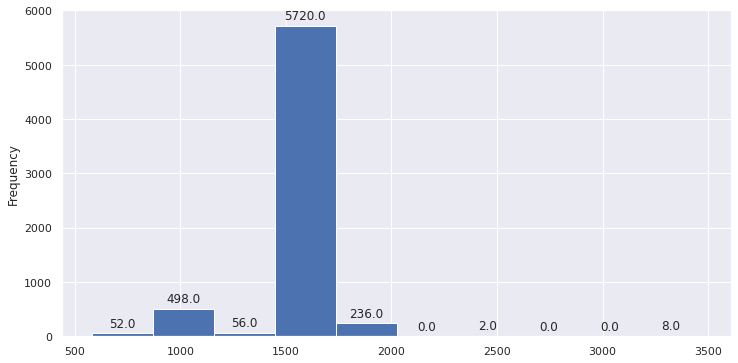

In [8]:
_=atom_counts_df.drop(columns='theoretical').sum(axis=1).plot.hist()
utils.show_barplot_values(_)

**We see that most of the chains have ~1500 atoms.**

### Total number of atoms per type

**Show the histogram:**

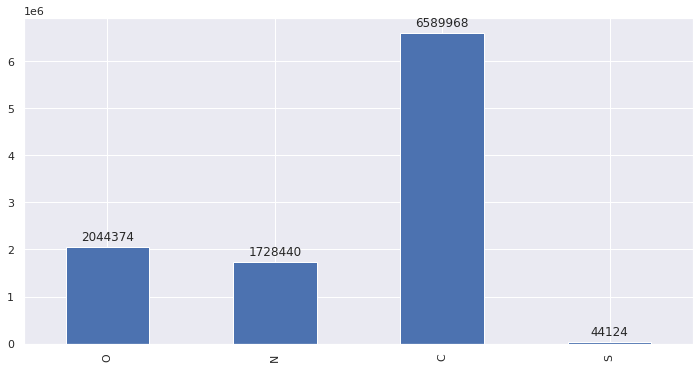

In [9]:
_=atom_counts_df.drop(columns='theoretical').sum(axis=0).plot.bar()
utils.show_barplot_values(_)

**We see the carbon is by far the most numerous atom type represented in the PDB files.**

**Obvious choice for that title would be hydrogen, however, there is in total only ~800 of them. This implies hydrogens are missing in the majority of files.**

### Missing atoms per chain

TODO: Do we want to add them later on? If yes, https://www.google.com/search?client=safari&rls=en&q=biopandas+count+missing+atoms+in+pdb&ie=UTF-8&oe=UTF-8

**Compute:**

In [17]:
atom_pdb_sums = atom_counts_df.drop(columns='theoretical').sum(axis=1) 
missing = atom_counts_df['theoretical'] - atom_pdb_sums
missing.head(n=3)

12E8:H    220
12E8:L    180
15C8:H    216
dtype: int64

**Show the histogram:**

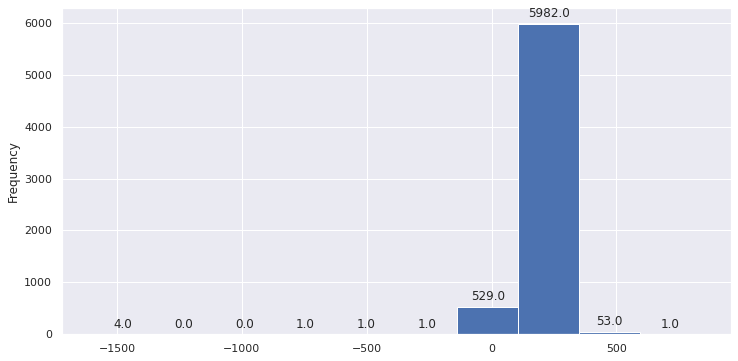

In [18]:
_ = missing.plot.hist()
utils.show_barplot_values(_)

**We see most of the chains have ~250 atoms missing.**

**Interestingly, there are few sequences that have more atoms than the theoretical count!**

In [15]:
atom_counts_df.loc[missing[missing < 0].index, :]

,O,N,C,S,theoretical
1A14:L,188,153,585,5,905
1A6U:L,182,153,593,4,909
1A6V:L,182,155,600,4,919
1A6W:L,182,148,598,4,919
1DQL:L,180,160,577,5,915
...,...,...,...,...,...
7TB8:L,186,169,614,4,920
7TLY:L,178,165,602,5,859
7UAP:L,191,170,631,5,949
7WLZ:L,185,171,605,6,955
